In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

In [4]:
import urllib.request
from io import BytesIO

In [5]:
#df = pd.read_excel('c:\\Users\\yaron\\Desktop\\ML_project\\2024q2.xlsx')

url = 'https://raw.githubusercontent.com/YaronRic/FireEventPred/main/2024q2.xlsx'
response = urllib.request.urlopen(url)
df = pd.read_excel(BytesIO(response.read()))
df.head()

,שנה,EventMonth,מחוז,EventAreaCode,תחום,EventTypeCode,מתאר,EventScenarioCode,תרחיש,מיקום,SettlementLamasCode,מספר אירועים
0,2024,6,דן,2168,אבטחה,4002,אבטחה,4014,אבטחת לוחמי אש בתשלום,תל אביב יפו,5000,11
1,2024,5,דן,2168,אבטחה,4002,אבטחה,4014,אבטחת לוחמי אש בתשלום,תל אביב יפו,5000,9
2,2024,4,דן,2168,אבטחה,4002,אבטחה,4014,אבטחת לוחמי אש בתשלום,תל אביב יפו,5000,3
3,2024,4,דן,2168,אבטחה,4002,אבטחה,4014,אבטחת לוחמי אש בתשלום,חולון,6600,2
4,2024,5,דן,2168,אבטחה,4002,אבטחה,4014,אבטחת לוחמי אש בתשלום,רמת גן,8600,2


In [6]:
df.columns

Index(['שנה', 'EventMonth', 'מחוז', 'EventAreaCode', 'תחום', 'EventTypeCode',
       'מתאר', 'EventScenarioCode', 'תרחיש', 'מיקום', 'SettlementLamasCode',
       'מספר אירועים'],
      dtype='object')

In [7]:
nan_count = df.isna().sum()
nan_count

שנה                    0
EventMonth             0
מחוז                   0
EventAreaCode          0
תחום                   0
EventTypeCode          0
מתאר                   0
EventScenarioCode      0
תרחיש                  0
מיקום                  0
SettlementLamasCode    0
מספר אירועים           0
dtype: int64

In [8]:
def region(df):
    df.rename(columns={'מחוז': 'region'}, inplace=True)
    region_mapping = {
        'דן': 'Dan',
        'דרום': 'South',
        'חוף': 'Coast',
        'יו"ש': 'Yehuda and Shomron',
        'ירושלים': 'Jerusalem',
        'מרכז': 'Center',
        'צפון': 'North'    }

    df['region'] = df['region'].replace(region_mapping)
    return df

In [9]:
def domain(df):
    df.rename(columns={'תחום': 'domain'}, inplace=True)
    region_mapping = {
        'אבטחה': 'Security',
        'חילוץ': 'Rescue',
        'חומ"ס': 'Hazardous materials',
        'שריפה': 'Fire',
            }

    df['domain'] = df['domain'].replace(region_mapping)
    return df

In [10]:
def description(df):
    df.rename(columns={'מתאר': 'description'}, inplace=True)
    description_mapping = {
            'אבטחה': 'Security',
            'אורבאני': 'Urban',
            'שטחים פתוחים': 'Open Areas',
            'שינוע': 'Logistics',
            'תווך תת קרקעי': 'Underground',
            'תחבורה': 'Transport',
            'תעשייה': 'Industry'
        }
    df['description'] = df['description'].replace(description_mapping)
    return df

In [11]:
def scenario(df):
    df.rename(columns={'תרחיש': 'scenario'}, inplace=True)
    scenario_mapping = {
        '3 רכבים ומעלה/מעורבות רכב ציבורי/מסחרי/צמ"ה': 'three vehicles or more/commercial/public vehicle',
        'אבטחת כבאים בתשלום בשטח עירוני': 'firefighter security in urban area',
        'אבטחת לוחמי אש בתשלום': 'firefighter security',
        'אובייקט שאינו מבנה': 'non-building object',
        'אירוע טב"ק': 'hazardous material event',
        'בע"ח במצוקה': 'animal in distress',
        'גז טבעי': 'natural gas',
        'גפ"מ': 'lpg',
        'גפ"מ / גט"ד': 'lpg / ng',
        'דליפה/שפך': 'leak/spill',
        'דליפת גז מרכב': 'gas leak from vehicle',
        'הדברה': 'pest control',
        'היערכות למז"א קיצוני': 'extreme weather preparation',
        'הצפה': 'flood',
        'חומ"ס': 'hazardous materials',
        'חייגן': 'emergency dialer',
        'חילוץ מיוחד גובה': 'special rescue height',
        'חילוץ מיוחד מים זורמים': 'special rescue flowing water',
        'חילוץ מיוחד צלילה': 'special rescue diving',
        'חילוץ מיוחד רק"ל מנהרה': 'special rescue lrt tunnel',
        'חילוץ ממעלית': 'elevator rescue',
        'חשש לחיי אדם במבנה': 'concern for life in building',
        'חשש לחיי אדם ברכב': 'concern for life in vehicle',
        'חשש קריסת מבנה': 'building collapse concern',
        'טב"ק': 'hazardous material',
        'כלי טייס': 'aircraft',
        'כלי שייט במים פתוחים': 'vessel in open water',
        'כלי שייט במעגנה / נמל': 'vessel in marina/port',
        'מבנה ברק"ל': 'lrt structure',
        'מגורים / משרדים 4 קומות ומעלה': 'residential/offices 4 floors and above',
        'מגורים / משרדים עד 3 קומות': 'residential/offices up to 3 floors',
        'מדורה ללא השגחה': 'unattended bonfire',
        'מיוצב': 'stabilized',
        'מנהרה / חניון': 'tunnel/parking lot',
        'סיוע לאזרח': 'civilian assistance',
        'סיוע לגורמים חבירים': 'assistance to other agencies',
        'סיור מבצעי': 'operational patrol',
        'פיצוץ טב"ק': 'hazardous material explosion',
        'כלי טייס': 'aircraft',
        'קריסת מבנה': 'Building collapse',
        'תאונת דרכים עד 2 רכבים פרטיים': 'Car accident involving up to 2 private vehicles',
        'תעשייה ומסחר עד 3 קומות': 'Industry and commerce up to 3 floors',
        'שריפת צמחייה באינדקס גבוה / קיצון': 'High Index/Extreme Vegetation Burning',
        'שריפת צמחייה באינדקס רגיל': 'Normal index vegetation burning',
        'רכב פרטי': 'private car',
        'פסולת': 'waste',
        'רכבת': 'rail',
        'רק"ל': 'RKL',
        'רכב ציבורי / מסחרי': 'public/industry car',
        'רכב שאינו מונע בנזין או סולר': 'A vehicle that does not run on gasoline or diesel',
        'שריפת יער': 'forest fire',
        'תאונת דרכים רק"ל': 'RKL accident',
        'תעשייה ומסחר 4 קומות ומעלה': 'Industry and commerce 4 floors and above',
        'ריח ממקור לא ידוע': 'unknown source odor',
        'ריח שרוף במבנה': 'burnt smell in building',
        'ריכוז אוכלוסיה': 'population concentration',
        }
    df['scenario'] = df['scenario'].replace(scenario_mapping)
    return df

In [12]:
def date(df):
    df['year'] = pd.to_datetime(df['year'], format='%Y', errors='coerce').dt.year
    df['month'] = pd.to_datetime(df['month'], format='%m', errors='coerce').dt.month
    return df

In [13]:
def rename(df):
    df.rename(columns={'EventMonth': 'month'}, inplace=True)
    df.rename(columns={'שנה': 'year'}, inplace=True)
    df.rename(columns={'מיקום': 'city'}, inplace=True)
    df.rename(columns={'מספר אירועים': 'EventsCount'}, inplace=True)
    return df

In [14]:
def clean_outliers(df, method='iqr', strategy='remove', replacement=None, z_thresh=3):
    columns = ['year','month']
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [15]:
def isFire(df):
    fire_scenarios = [
 'unattended bonfire',
 'forest fire']

    df['isFire'] = df['scenario'].isin(fire_scenarios).astype(int)
    return df

In [16]:
def severity(df):
    severity_mapping = {
        'natural gas': 3,
        'lpg': 3,
        'leak/spill': 3,
        'hazardous materials': 3,
        'lpg / ng': 3,
        'gas leak from vehicle': 3,
        'special rescue height': 3,
        'elevator rescue': 3,
        'concern for life in building': 3,
        'building collapse concern': 3,
        'Building collapse': 3,
        'special rescue diving': 3,
        'three vehicles or more/commercial/public vehicle': 3,
        'special rescue lrt tunnel': 3,
        'concern for life in vehicle': 3,
        'residential/offices 4 floors and above': 3,
        'Industry and commerce 4 floors and above':3,
        'unattended bonfire': 3,
        'High Index/Extreme Vegetation Burning': 3,
        'forest fire': 3,
        'vessel in marina/port': 3,
        'rail': 3,
        'hazardous material': 3,
        'hazardous material explosion': 3,
        'hazardous material event': 3,
        'special rescue flowing water': 3,
        'aircraft': 3,
        
        'flood': 2,
        'civilian assistance': 2,
        'assistance to other agencies': 2,
        'Car accident involving up to 2 private vehicles': 2,
        'non-building object': 2,
        'lrt structure': 2,
        'residential/offices up to 3 floors': 2,
        'burnt smell in building': 2,
        'Industry and commerce up to 3 floors': 2,
        'waste': 2,
        'Normal index vegetation burning': 2,
        'tunnel/parking lot': 2,
        'private car': 2,
        'public/industry car': 2,
        'RKL': 2,
        'RKL accident': 2,
        'extreme weather preparation': 2,
        'vessel in open water': 2,
        
        'firefighter security': 1,
        'operational patrol': 1,
        'firefighter security in urban area': 1,
        'pest control': 1,
        'stabilized': 1,
        'animal in distress': 1,
        'emergency dialer': 1,
        'A vehicle that does not run on gasoline or diesel': 1,
        'unknown source odor': 1,
        'population concentration':1,
    }

    df['severity'] = df['scenario'].map(severity_mapping)
    df['severity'] = df['severity'].astype(int)
    return df

In [17]:
def prepare_date(df):
    #Organize
    region(df)
    domain(df)
    description(df)
    scenario(df)
    
    #cleaning and Fitting
    rename(df)
    date(df)
    clean_outliers(df)
    
    #Adding
    isFire(df)
    severity(df)
    return df

In [18]:
df = prepare_date(df)

In [19]:
df.isFire.unique()

array([0, 1])

---
# Data Information
---

In [20]:
cols = df.columns
cols

Index(['year', 'month', 'region', 'EventAreaCode', 'domain', 'EventTypeCode',
       'description', 'EventScenarioCode', 'scenario', 'city',
       'SettlementLamasCode', 'EventsCount', 'isFire', 'severity'],
      dtype='object')

In [21]:
df.shape

(9314, 14)

In [22]:
df.isna().sum()

year                   0
month                  0
region                 0
EventAreaCode          0
domain                 0
EventTypeCode          0
description            0
EventScenarioCode      0
scenario               0
city                   0
SettlementLamasCode    0
EventsCount            0
isFire                 0
severity               0
dtype: int64

In [23]:
df.dtypes

year                    int32
month                   int32
region                 object
EventAreaCode           int64
domain                 object
EventTypeCode           int64
description            object
EventScenarioCode       int64
scenario               object
city                   object
SettlementLamasCode    object
EventsCount             int64
isFire                  int32
severity                int32
dtype: object

In [24]:
df['severity'].unique()

array([1, 3, 2])

---
# Visualization by Ploting
---

---
### Pie
---

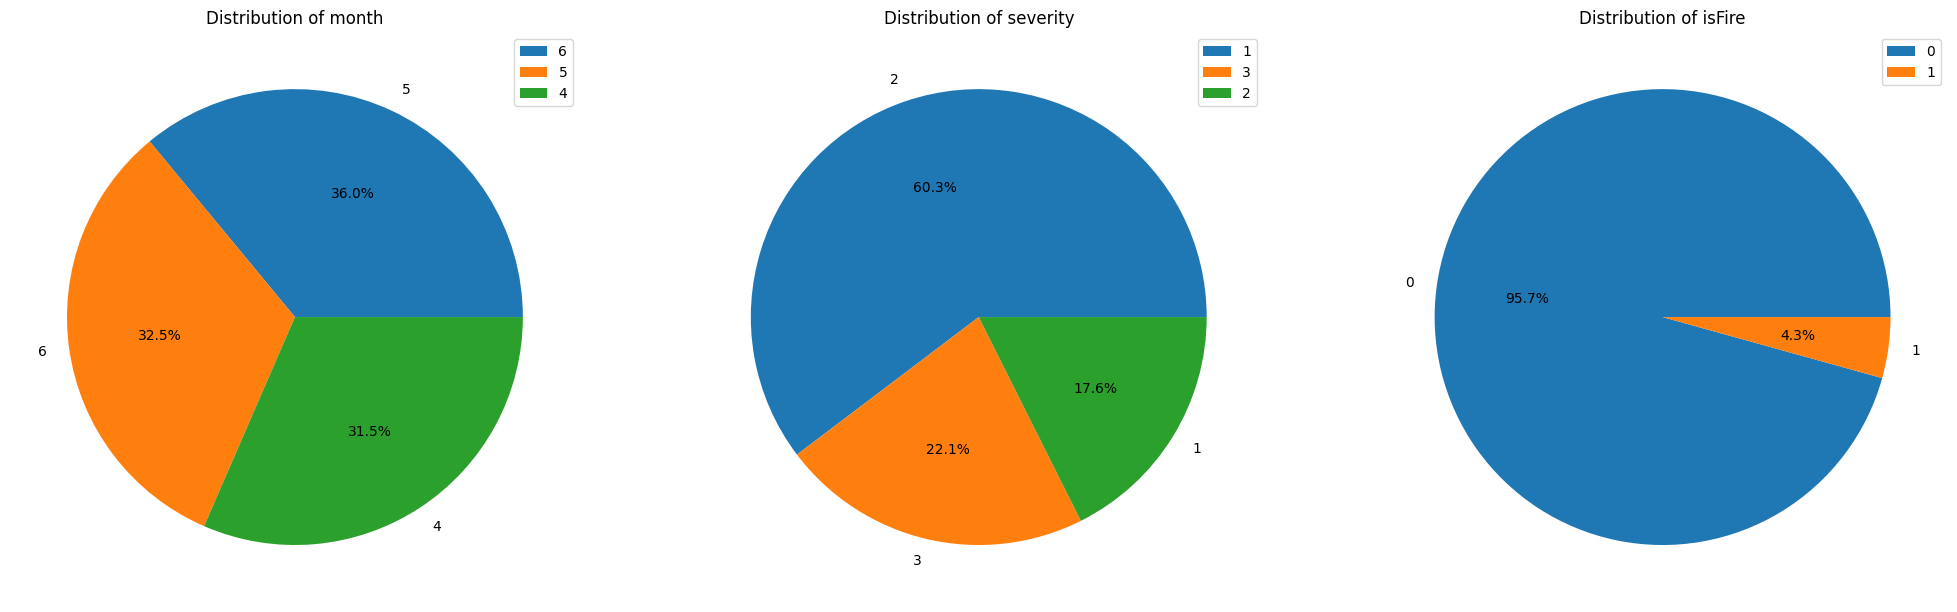

In [25]:
cols_pie = ['month', 'severity', 'isFire']

plt.figure(figsize=(25,20))
for i, col in enumerate(cols_pie):
    plt.subplot(1, 3, i+1)
    df[col].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.legend(list(df[col].unique()))
    df[col].value_counts()
    plt.title(f"Distribution of {col}", fontsize=12)
    plt.ylabel('')

plt.show()

---
### Hist
---

In [26]:
df['EventsCount'].unique()

array([ 11,   9,   3,   2,   1,  32,  20,  19,  18,  17,  16,  15,  13,
         8,   7,   6,   5,   4,  91,  79,  54,  14,  12,  10, 111,  97,
        85,  39,  34,  31,  27,  25,  23,  22,  21, 117,  93,  73,  42,
        40,  38,  35,  30,  28,  80,  74,  70,  33,  66,  56,  55,  29,
        69,  52,  24,  95,  62,  37, 165,  92,  68,  67,  45,  43,  36,
        61,  60,  51,  26,  77,  75,  65,  48, 124, 107, 133, 114,  59,
        47,  46,  41,  83,  76, 108,  94,  64,  57,  96, 247, 140,  50,
        72,  44, 106, 103, 265, 343, 299, 232,  49, 797, 534, 224, 112,
       191, 153, 123,  71, 222], dtype=int64)

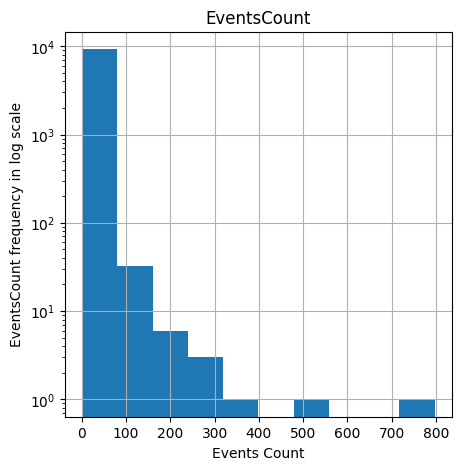

In [27]:
cols_bar = ['month', 'region', 'EventAreaCode', 'domain', 'EventTypeCode', 'description', 'severity']

plt.figure(figsize=(5, 5))
df['EventsCount'].hist(log=True)
plt.title('EventsCount')
plt.xlabel('Events Count')
plt.ylabel('EventsCount frequency in log scale')
plt.show()

---
### Box
---

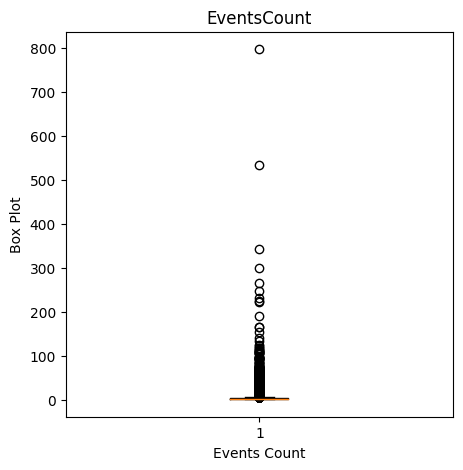

In [28]:
plt.figure(figsize=(5, 5))
plt.boxplot(df['EventsCount'])

plt.title('EventsCount')
plt.xlabel('Events Count')
plt.ylabel('Box Plot')
plt.show()

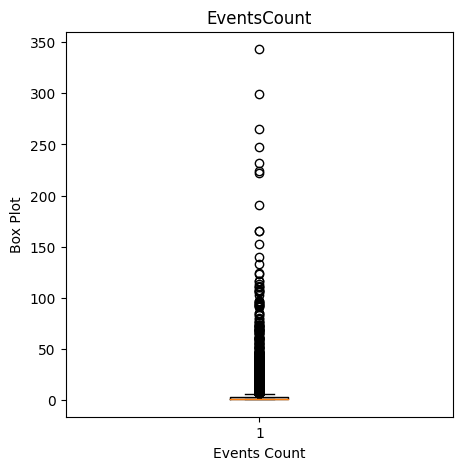

In [29]:
top_outliers = df['EventsCount'].nlargest(2)
df = df[~df['EventsCount'].isin(top_outliers)]

plt.figure(figsize=(5, 5))
plt.boxplot(df['EventsCount'])

plt.title('EventsCount')
plt.xlabel('Events Count')
plt.ylabel('Box Plot')
plt.show()

---
### Bar
---

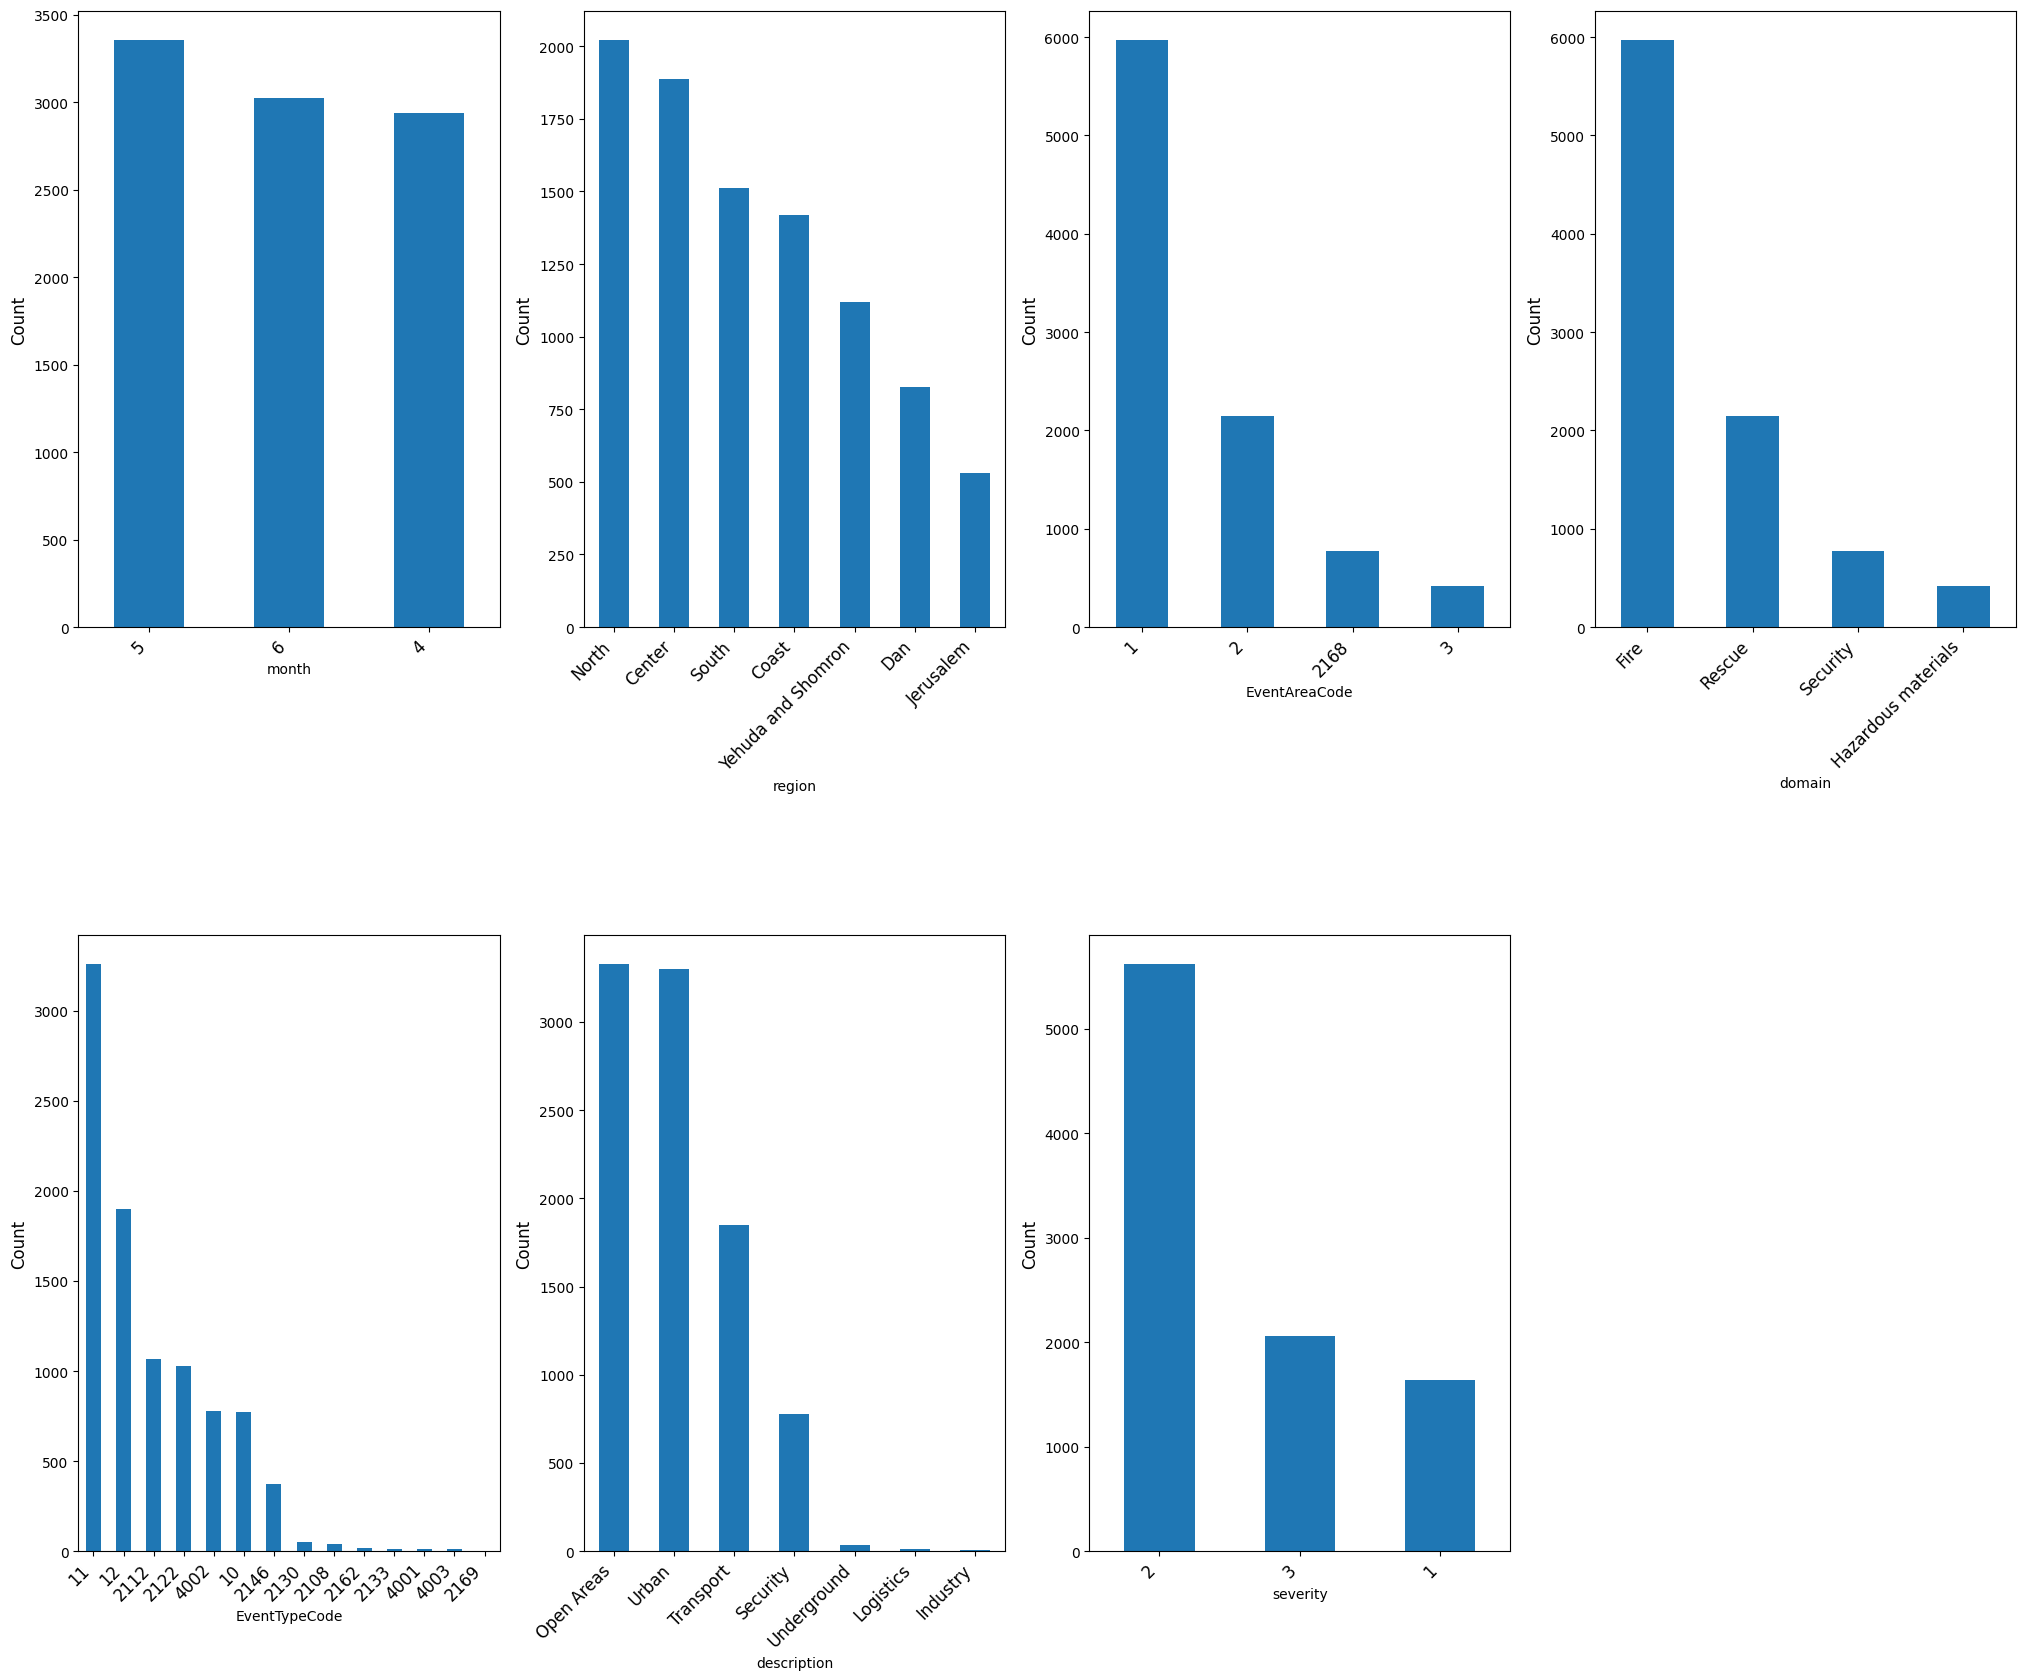

In [30]:
plt.figure(figsize=(25,20))
for i, col in enumerate(cols_bar):
    plt.subplot(2, 4, i+1)
    df[col].value_counts().plot(kind='bar')
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, fontsize=12, ha='right')
    
plt.subplots_adjust(hspace=0.5)
plt.show()

---
# Prepare the Data
---

In [31]:
#categorical_cols = df.select_dtypes(include='object').columns
#encoded_df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [32]:
#encoded_df.head()

We have checked the option to use get_dummies and onehotencoder. However, we have tested and checked the relevant of these.

We have discovered that using get_dummies or OneHotEncoder can lead to high VIF values and fraud correlations because of the increase in dimensions and redundancy of dummy variables.

In some situations, it makes more sense to use models that can handle categorical features directly. This allows us to avoid the huge size and dimention of the data and the potentially complex process of converting categorical features into numerical ones using techniques like these.

---
## Chek Multicollinearity
---

In [33]:
numeric_df = df.select_dtypes(include=np.number)

---
##### VIF
---

In [34]:
def calculate_vif(df):
    n_cols = df.shape[1]
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_list = []
    for i in range(n_cols):
        vif = variance_inflation_factor(df.values, i)
        vif_list.append(vif)
    vif_data["VIF"] = vif_list
    return vif_data

In [35]:
vif_df = calculate_vif(numeric_df)
print(vif_df)

             Feature        VIF
0               year  98.321080
1              month   1.003329
2      EventAreaCode   3.465083
3      EventTypeCode   5.389283
4  EventScenarioCode   3.077408
5        EventsCount   1.008652
6             isFire   1.322636
7           severity   2.103082


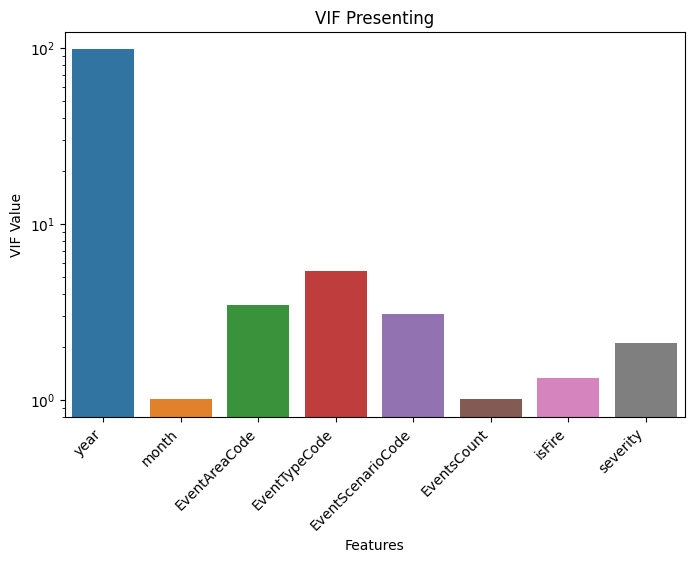

In [36]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Feature', y='VIF', data=vif_df, log=True)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('VIF Value')
plt.title('VIF Presenting')
plt.show()

The year feature has a VIF of 90.29, which indicates strong multicollinearity.
We need to drop this col.

There are other features with suspicious VIF value, suggesting that they don't indicate strong multicollinearity.
We need to  check by correlations.

In [37]:
df = df.drop(columns=['year'])

In [38]:
df.dtypes

month                   int32
region                 object
EventAreaCode           int64
domain                 object
EventTypeCode           int64
description            object
EventScenarioCode       int64
scenario               object
city                   object
SettlementLamasCode    object
EventsCount             int64
isFire                  int32
severity                int32
dtype: object

---
##### Correlation
---

In [39]:
numeric_df = df.select_dtypes(include=np.number)

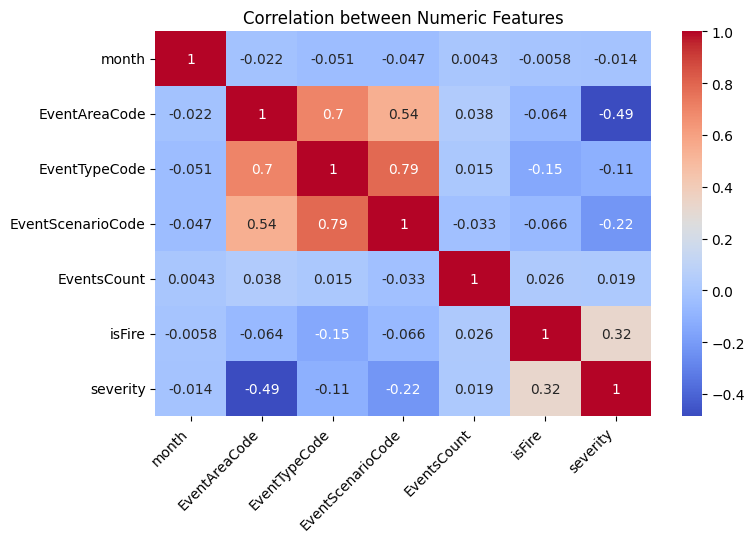

In [40]:
# Calculate and visualize correlations in the dataset
plt.figure(figsize=(8, 5))
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between Numeric Features')
plt.xticks(rotation=45, ha='right')
plt.show()

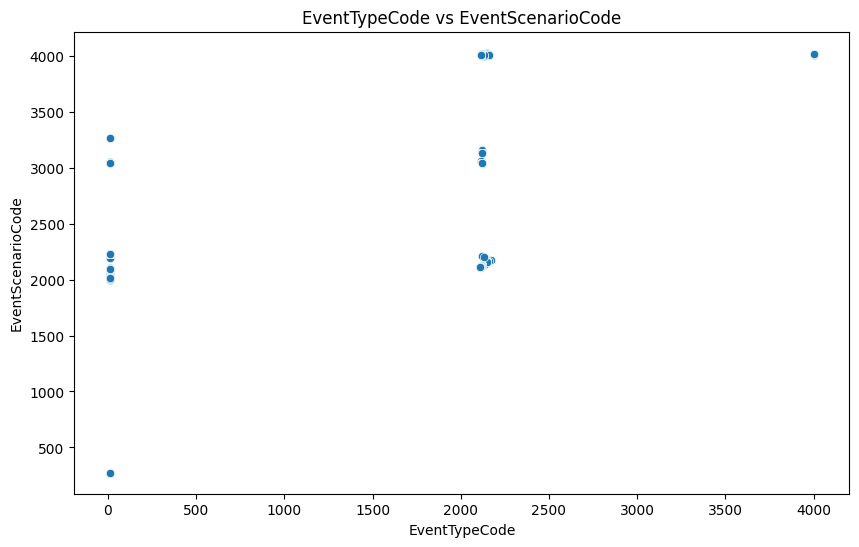

In [41]:
# Plotting the scatter plot for correlation between EventTypeCode and EventScenarioCode
plt.figure(figsize=(10, 6))
sns.scatterplot(x='EventTypeCode', y='EventScenarioCode', data=df)
plt.xlabel('EventTypeCode')
plt.ylabel('EventScenarioCode')
plt.title('EventTypeCode vs EventScenarioCode')
plt.show()

EventTypeCode and EventScenarioCode contain high positive correlation. This may indicates that these features provide similar information (multicollinearity).

Because they didn't have high VIF, instead of dropping one of them, we will use Ridge Regression, which can help the multicollinearity situation by shrinking coefficients of correlated features.

---
##### Chi Square Test
---

In [42]:
def chi_square_test(df, categorical_cols):
    for col1 in categorical_cols:
        for col2 in categorical_cols:
            if col1 != col2:
                contingency_table = pd.crosstab(df[col1], df[col2])
                chi2, p, _, _ = chi2_contingency(contingency_table)
                print(f"Chi-Square Test between {col1} and {col2}: chi2 = {chi2:.4f}, p-value = {p:.4f}")

In [43]:
categorical_cols = df.select_dtypes(include='object').columns

In [44]:
chi_square_test(df, categorical_cols)

Chi-Square Test between region and domain: chi2 = 301.9549, p-value = 0.0000
Chi-Square Test between region and description: chi2 = 450.1169, p-value = 0.0000
Chi-Square Test between region and scenario: chi2 = 1445.2847, p-value = 0.0000
Chi-Square Test between region and city: chi2 = 52089.0649, p-value = 0.0000
Chi-Square Test between region and SettlementLamasCode: chi2 = 42980.1775, p-value = 0.0000
Chi-Square Test between domain and region: chi2 = 301.9549, p-value = 0.0000
Chi-Square Test between domain and description: chi2 = 12683.4177, p-value = 0.0000
Chi-Square Test between domain and scenario: chi2 = 27930.1040, p-value = 0.0000
Chi-Square Test between domain and city: chi2 = 4991.1925, p-value = 0.9991
Chi-Square Test between domain and SettlementLamasCode: chi2 = 3592.3163, p-value = 0.0001
Chi-Square Test between description and region: chi2 = 450.1169, p-value = 0.0000
Chi-Square Test between description and domain: chi2 = 12683.4177, p-value = 0.0000
Chi-Square Test b

Based on the Chi-Square Test, the cols that show multicollinearity (p-value = 0):

<ol>
<li> Region & Domain
<li> Region & Description
<li> Region & SettlementLamasCode
<li> Scenario & Description
<li> Scenario & Region
<li> City & Region
<li> SettlementLamasCode & City

Based on the Chi-Square Test, the cols that show multicollinearity (p-value = 1):

<ol>
<li> Scenario & City
<li> Scenario & SettlementLamasCode
<li> Description & City
<li> City & Scenario

Thus, we have checked these cols carefully, by their meanning. The cols adds meaning to the data.

---
# Clustring
---

c:\Users\yaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


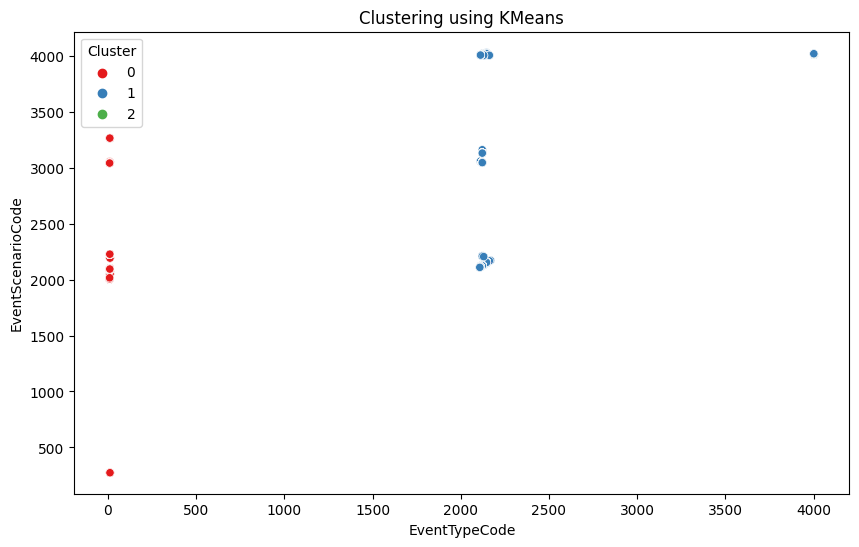

In [45]:
kmeans = KMeans(n_clusters=3, random_state=42)

# קיבוץ הנתונים
df['Cluster'] = kmeans.fit_predict(numeric_df)

# תצוגת תוצאות הקיבוץ
plt.figure(figsize=(10, 6))
sns.scatterplot(x='EventTypeCode', y='EventScenarioCode', hue='Cluster', data=df, palette='Set1')
plt.title('Clustering using KMeans')
plt.show()

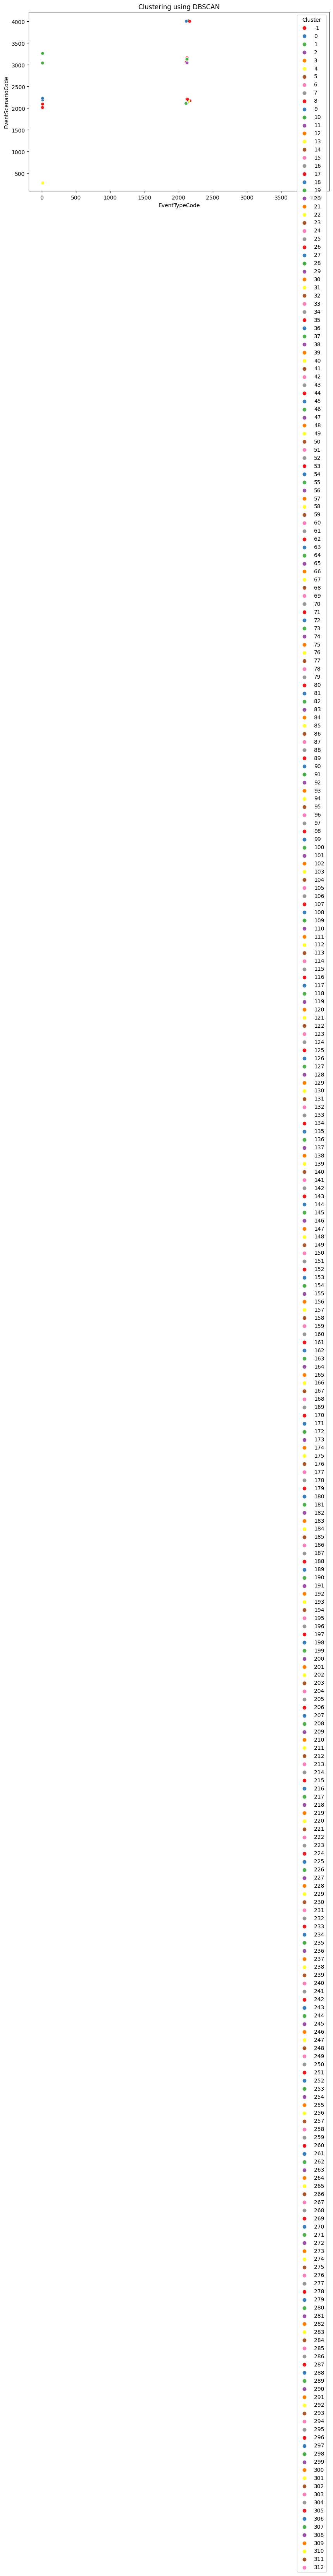

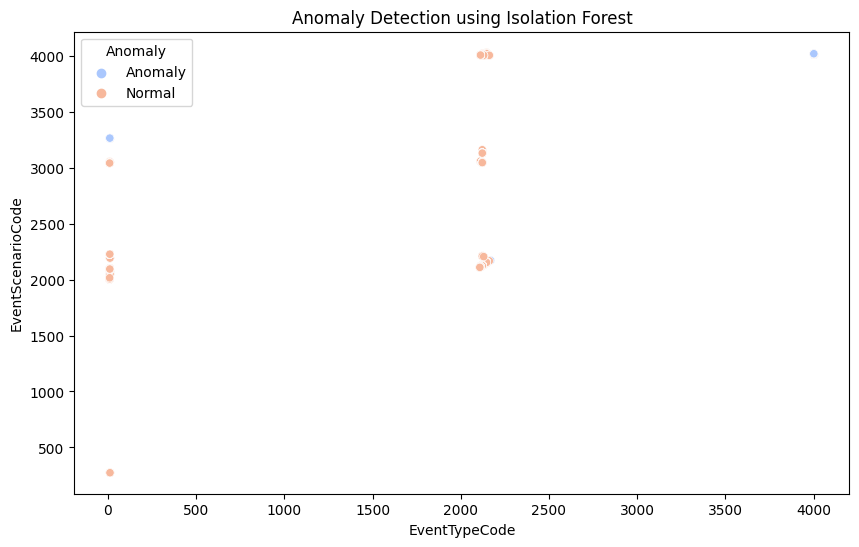

In [46]:
dbscan = DBSCAN(eps=0.5, min_samples=5)

# קיבוץ הנתונים
df['Cluster'] = dbscan.fit_predict(numeric_df)

# תצוגת תוצאות הקיבוץ
plt.figure(figsize=(10, 6))
sns.scatterplot(x='EventTypeCode', y='EventScenarioCode', hue='Cluster', data=df, palette='Set1')
plt.title('Clustering using DBSCAN')
plt.show()




# מודל של Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# חיזוי האנומליות
df['Anomaly'] = iso_forest.fit_predict(numeric_df)

# 1 מציין אנומליה, -1 מציין שלא אנומליה
df['Anomaly'] = df['Anomaly'].map({1: 'Normal', -1: 'Anomaly'})

# הצגת תוצאות האנומליות
plt.figure(figsize=(10, 6))
sns.scatterplot(x='EventTypeCode', y='EventScenarioCode', hue='Anomaly', data=df, palette='coolwarm')
plt.title('Anomaly Detection using Isolation Forest')
plt.show()

In [47]:
'''clf = DecisionTreeClassifier()
clf.fit(X_transformed, kmeans_labels)
importances = clf.feature_importances_
importances'''

'clf = DecisionTreeClassifier()\nclf.fit(X_transformed, kmeans_labels)\nimportances = clf.feature_importances_\nimportances'

---
# Modeling
---

In [48]:
feature_selector = SelectKBest(score_func=f_classif, k=10)

In [49]:
# Define models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}

In [50]:
# Convert all categorical col to string
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype(str)


X = df.drop(columns=['isFire'])
y = df['isFire']

categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

# Scaling numerical values
numerical_transformer = StandardScaler()

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [51]:
# Feature selection
feature_selector = SelectKBest(score_func=f_classif, k=10)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Define models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}

(7449, 14) (1863, 14) (7449,) (1863,)


In [52]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_score, recall_score, f1_score

In [53]:
results = []

for model_name, model in models.items():
    # pipeline of preprocessing, FS, and model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selector', feature_selector),
        ('model', model)
    ])

    # Fitting
    pipeline.fit(X_train, y_train)

    # Predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline.named_steps['model'], 'predict_proba') else None

    # Evaluations
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 'N/A'

    results.append({
        'Model': model_name,
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"Confusion Matrix for {model_name}:")
    print(confusion_matrix(y_test, y_pred))
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

c:\Users\yaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\yaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\yaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\yaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories wi

RandomForest Accuracy: 1.0000
Confusion Matrix for RandomForest:
[[1784    0]
 [   0   79]]
Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1784
           1       1.00      1.00      1.00        79

    accuracy                           1.00      1863
   macro avg       1.00      1.00      1.00      1863
weighted avg       1.00      1.00      1.00      1863

--------------------------------------------------
LogisticRegression Accuracy: 0.9989
Confusion Matrix for LogisticRegression:
[[1784    0]
 [   2   77]]
Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1784
           1       1.00      0.97      0.99        79

    accuracy                           1.00      1863
   macro avg       1.00      0.99      0.99      1863
weighted avg       1.00      1.00      1.00      1863

-------------

c:\Users\yaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\yaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\yaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\yaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories wi

GradientBoosting Accuracy: 1.0000
Confusion Matrix for GradientBoosting:
[[1784    0]
 [   0   79]]
Classification Report for GradientBoosting:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1784
           1       1.00      1.00      1.00        79

    accuracy                           1.00      1863
   macro avg       1.00      1.00      1.00      1863
weighted avg       1.00      1.00      1.00      1863

--------------------------------------------------
SVM Accuracy: 1.0000
Confusion Matrix for SVM:
[[1784    0]
 [   0   79]]
Classification Report for SVM:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1784
           1       1.00      1.00      1.00        79

    accuracy                           1.00      1863
   macro avg       1.00      1.00      1.00      1863
weighted avg       1.00      1.00      1.00      1863

----------------------------------------------

In [54]:
# Summary results
results_df = pd.DataFrame(results)
print("\nResults before Hyperparameter Tuning:")
print(results_df)


Results before Hyperparameter Tuning:
                Model  roc_auc  precision    recall        f1
0        RandomForest      1.0        1.0  1.000000  1.000000
1  LogisticRegression      1.0        1.0  0.974684  0.987179
2    GradientBoosting      1.0        1.0  1.000000  1.000000
3                 SVM      1.0        1.0  1.000000  1.000000


In [55]:
if hasattr(pipeline.named_steps['model'], 'feature_importances_'):
    importances = pipeline.named_steps['model'].feature_importances_
    feature_names = X_train.columns if hasattr(X_train, 'columns') else range(X_train.shape[1])
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print(f"Top Features for {model_name}:")
    print(importance_df.head(10))
    print("-" * 50)
elif hasattr(pipeline.named_steps['model'], 'coef_'):
    coefficients = pipeline.named_steps['model'].coef_.ravel()
    feature_names = X_train.columns if hasattr(X_train, 'columns') else range(X_train.shape[1])
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
    coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)
    print(f"Top Features for {model_name}:")
    print(coef_df.head(10))
    print("-" * 50)

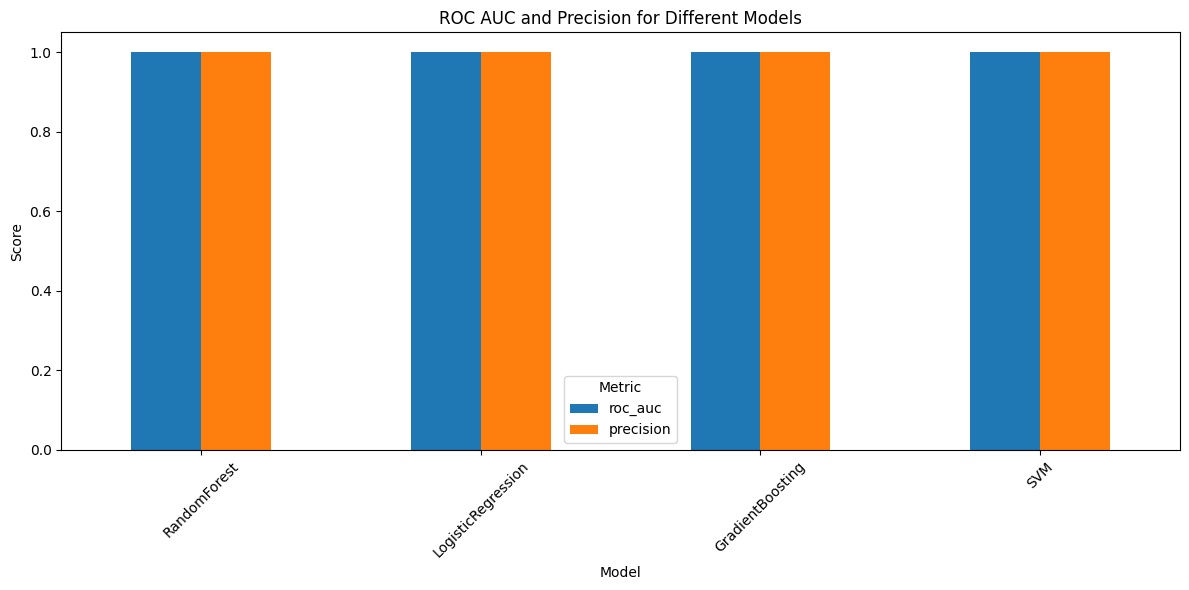

In [56]:
# Plot ROC AUC and Precision for each model
plt.figure(figsize=(12, 6))
ax = plt.gca()

results_df.set_index('Model')[['roc_auc', 'precision']].plot(kind='bar', ax=ax)
plt.title('ROC AUC and Precision for Different Models')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

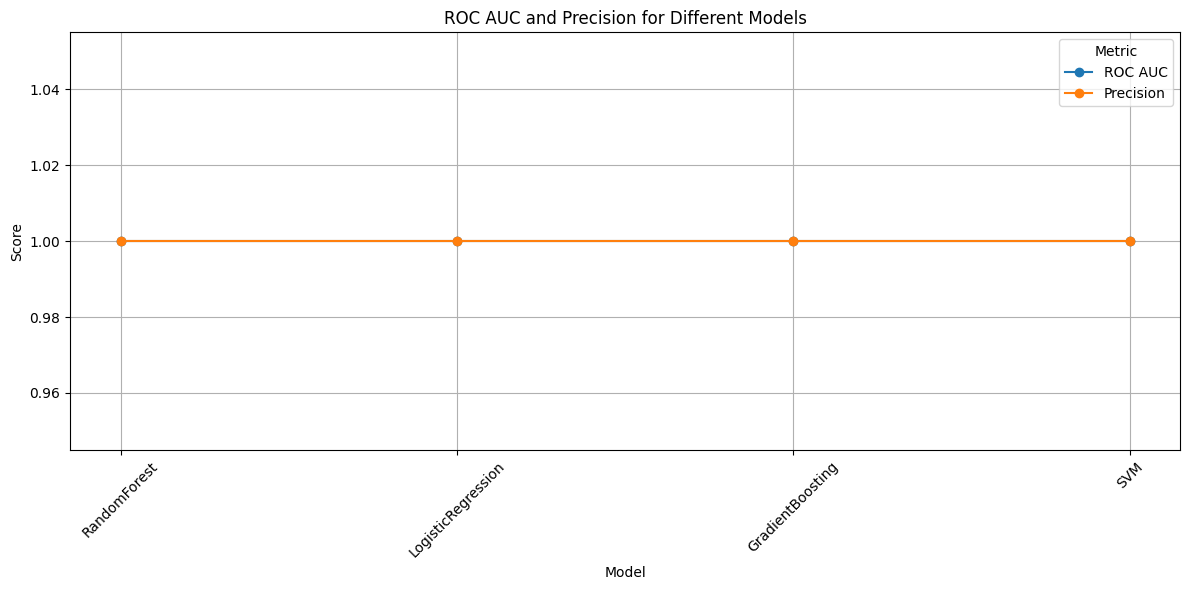

In [57]:
# Plot ROC AUC and Precision for each model (Line Plot)
plt.figure(figsize=(12, 6))
plt.plot(results_df['Model'], results_df['roc_auc'], marker='o', linestyle='-', label='ROC AUC')
plt.plot(results_df['Model'], results_df['precision'], marker='o', linestyle='-', label='Precision')
plt.title('ROC AUC and Precision for Different Models')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.grid(True)
plt.tight_layout()
plt.show()